# 1.0 - IMPORTAÇÃO DE PACOTES

In [1]:
# Manipulação de Dados
import numpy as np
import pandas as pd

# Visualização de Dados
import matplotlib.pyplot as plt
import matplotlib as mpl
from pylab import rcParams

## 1.0.1 - VERSÕES DOS PACOTES INSTALADOS

In [2]:
%reload_ext watermark
%watermark -a 'Versões dos pacotes instalados neste projeto' --iversions

pandas     1.1.2
matplotlib 3.3.2
numpy      1.19.2
Versões dos pacotes instalados neste projeto


# 2.0 - CARREGAMENTO DO DATASET

In [3]:
dados_treino = pd.read_csv('dataset4.txt')

In [4]:
dados_teste = pd.read_csv('dataset5.txt')

In [5]:
dados_teste.head()

,ID,Datetime
0,18288,26-09-2019 00:00
1,18289,26-09-2019 01:00
2,18290,26-09-2019 02:00
3,18291,26-09-2019 03:00
4,18292,26-09-2019 04:00


In [6]:
dados_treino.head()

,ID,Datetime,Count
0,0,25-08-2017 00:00,8
1,1,25-08-2017 01:00,2
2,2,25-08-2017 02:00,6
3,3,25-08-2017 03:00,2
4,4,25-08-2017 04:00,2


# 3.0 - ANÁLISE EXPLORATÓRIA

In [7]:
df3_treino = dados_treino.copy()
df3_teste = dados_teste.copy()

#### Verificando o tipo dos dados nos Datasets de Treino e Teste

In [8]:
df3_treino.dtypes

ID           int64
Datetime    object
Count        int64
dtype: object

In [9]:
df3_teste.dtypes

ID           int64
Datetime    object
dtype: object

#### Convertendo a coluna DateTime de ambos os Datasets para o tipo correto

In [10]:
df3_treino.Datetime = pd.to_datetime(df3_treino.Datetime, format='%d-%m-%Y %H:%M')
df3_teste.Datetime = pd.to_datetime(df3_teste.Datetime, format='%d-%m-%Y %H:%M')

In [11]:
df3_treino.dtypes

ID                   int64
Datetime    datetime64[ns]
Count                int64
dtype: object

In [12]:
df3_teste.dtypes

ID                   int64
Datetime    datetime64[ns]
dtype: object

#### Derivando o máximo de detalhes da coluna 'Datetime' dos Datasets

In [13]:
for i in (df3_teste, df3_treino):
    i['ano'] = i.Datetime.dt.year
    i['mes'] = i.Datetime.dt.month
    i['dia'] = i.Datetime.dt.day
    i['hora'] = i.Datetime.dt.hour
    i['dia_semana'] = i.Datetime.dt.dayofweek

In [14]:
df3_treino.head(3)

,ID,Datetime,Count,ano,mes,dia,hora,dia_semana
0,0,2017-08-25 00:00:00,8,2017,8,25,0,4
1,1,2017-08-25 01:00:00,2,2017,8,25,1,4
2,2,2017-08-25 02:00:00,6,2017,8,25,2,4


In [15]:
df3_teste.head(3)

,ID,Datetime,ano,mes,dia,hora,dia_semana
0,18288,2019-09-26 00:00:00,2019,9,26,0,3
1,18289,2019-09-26 01:00:00,2019,9,26,1,3
2,18290,2019-09-26 02:00:00,2019,9,26,2,3


#### Removendo a coluna 'ID'dos Datasets que são irrelevantes para este projeto

In [16]:
df3_teste = df3_teste.drop(columns='ID')
df3_treino = df3_treino.drop(columns='ID') 

## 3.0.1 -  Trabalhando com o Dataset de Treino

##### Criando uma coluna categórica para Finais de Semana e Dias da Semana, onde 1 = Fim de Semana e 0 = Dia da Semana Comum

In [17]:
def fimDeSemana(registro):
    if registro.dayofweek == 5 or registro.dayofweek == 6:
        return 1
    else:
        return 0 

In [18]:
df3_treino['final_semana'] = df3_treino.Datetime.apply(fimDeSemana)

In [19]:
df3_treino.sample(5)

,Datetime,Count,ano,mes,dia,hora,dia_semana,final_semana
1838,2017-11-09 14:00:00,10,2017,11,9,14,3,0
2278,2017-11-27 22:00:00,26,2017,11,27,22,0,0
12859,2019-02-11 19:00:00,304,2019,2,11,19,0,0
8682,2018-08-21 18:00:00,202,2018,8,21,18,1,0
17716,2019-09-02 04:00:00,212,2019,9,2,4,0,0


##### Definindo com índice do Dataset a coluna 'Datetime'

In [20]:
df3_treino.index = df3_treino['Datetime']

##### Plotando um gráfico de demanda de transporte na região

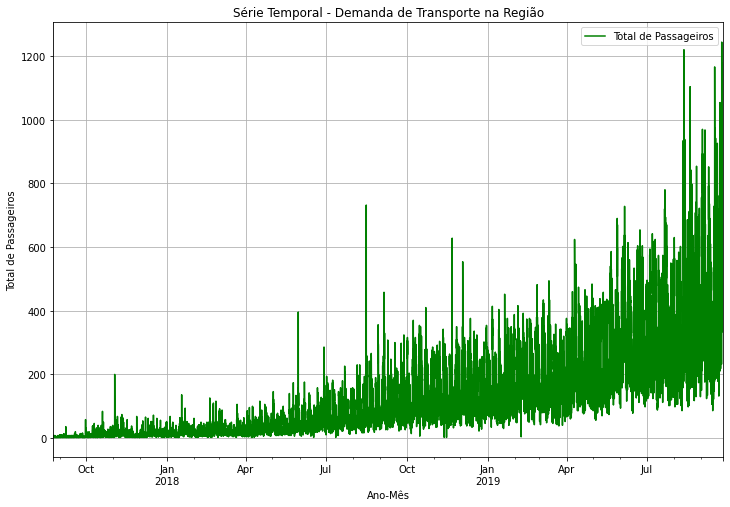

In [36]:
plt.figure(figsize=(12,8))
plt.title('Série Temporal - Demanda de Transporte na Região')
df3_treino.Count.plot(label = 'Total de Passageiros', color = 'green',grid=True )
plt.xlabel('Ano-Mês')
plt.ylabel('Total de Passageiros')
plt.legend(loc='best')
plt.show();

No gráfico acima percebe-se que há uma tendência de aumento de demanda de transporte na região.

##### Plotando um gráfico de barras da média de demanda de transporte na região por ano

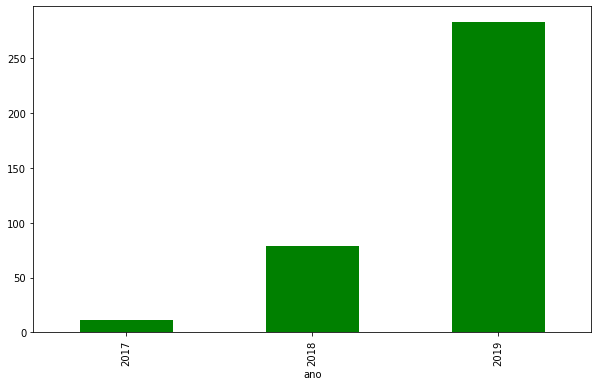

In [40]:
plt.figure(figsize=(10,6))
df3_treino.groupby('ano')['Count'].mean().plot.bar(color='green');

Mais uma vez confirmando a crescente demanda

##### Plotando um gráfico de barras com a média de demanda de transporte por mês

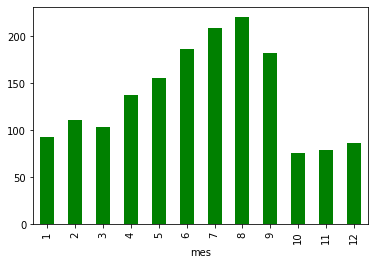

In [23]:
df3_treino.groupby('mes')['Count'].mean().plot.bar(color='green');

Pode-se observar um pico no mês de Agosto

##### Plotando um gráfico com a média de demanda de transporte mensal por ano

In [24]:
mma = df3_treino.groupby(['ano','mes'])['Count'].mean()

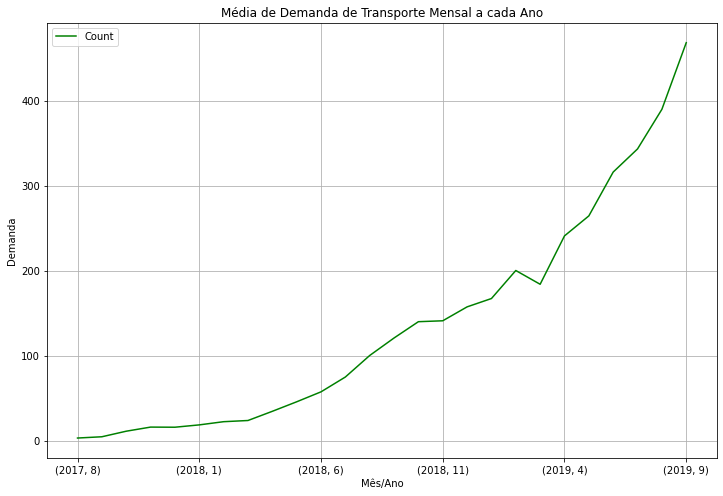

In [25]:
plt.figure(figsize=(12,8))
mma.plot(color='green', grid=True)
plt.title('Média de Demanda de Transporte Mensal a cada Ano')
plt.ylabel('Demanda')
plt.xlabel('Mês/Ano')
plt.legend(loc='best')
plt.show();

##### Plotando um gráfico com a média de demanda de transporte diária do mês

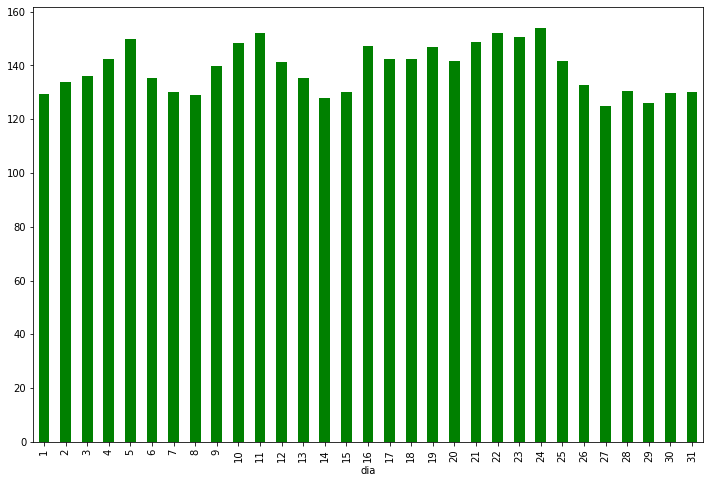

In [26]:
plt.figure(figsize=(12,8))
df3_treino.groupby('dia')['Count'].mean().plot.bar(color='green');

##### Plotando um gráfico com a média de demanda de transporte a cada hora do dia

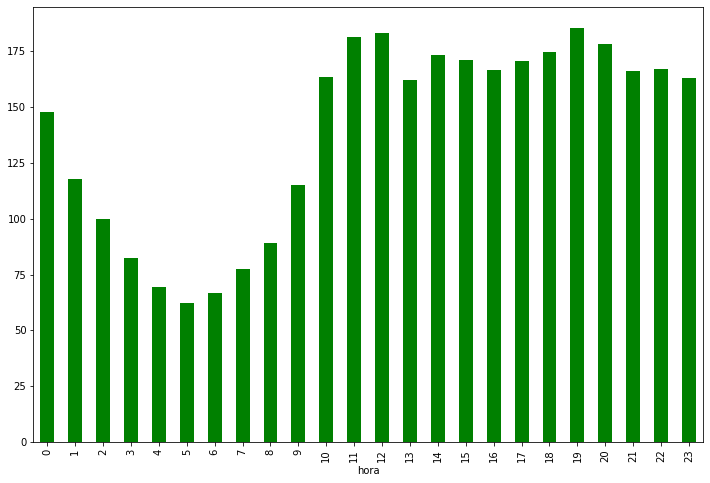

In [27]:
plt.figure(figsize=(12,8))
df3_treino.groupby('hora')['Count'].mean().plot.bar(color='green');

Observa-se que durante a madrugada a demanda cai.

##### Plotando um gráfico para analisar a demanda no final de semana X dia da semana

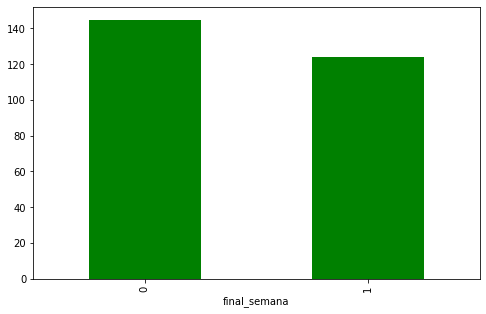

In [28]:
plt.figure(figsize=(8,5))
df3_treino.groupby('final_semana')['Count'].mean().plot.bar(color='green');

Observe que nos finais de semana a demanda cai um pouco.

##### Plotando um gráfico com 4 séries (demanda média por mês, dia, semana, hora e ano) para confirmar a tendência de crescimento.

In [29]:
media_ano = df3_treino.resample('Y').mean()
media_mes = df3_treino.resample('M').mean()
media_semana = df3_treino.resample('W').mean()
media_dia = df3_treino.resample('d').mean()
media_hora = df3_treino.resample('H').mean()

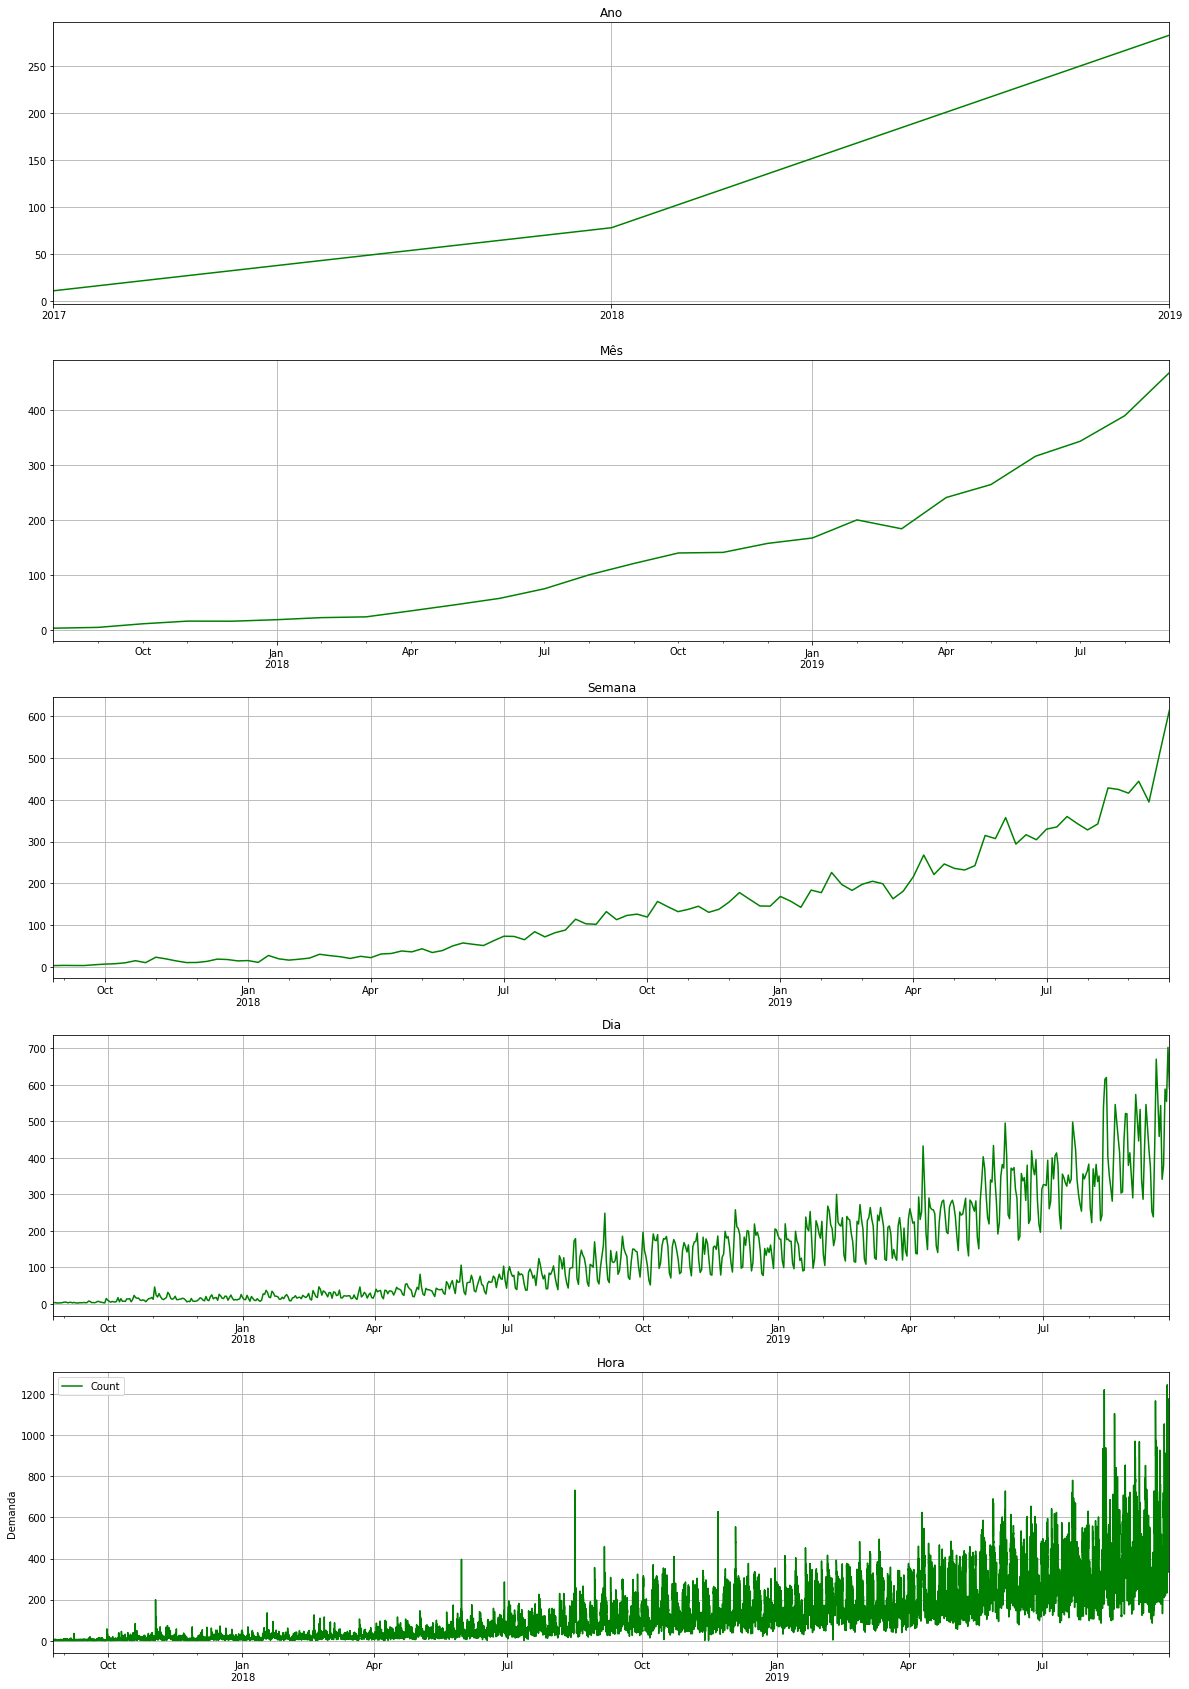

In [30]:
rcParams['figure.figsize'] = 20, 30
fig, axs = plt.subplots(5,1);
media_ano.Count.plot(title='Ano', ax=axs[0], color='green', xlabel='', grid=True);
media_mes.Count.plot(title='Mês', ax=axs[1], color='green', xlabel='', grid=True);
media_semana.Count.plot(title='Semana', ax=axs[2], color='green', xlabel='', grid=True);
media_dia.Count.plot(title='Dia', ax=axs[3], color='green', xlabel='', grid=True);
media_hora.Count.plot(title='Hora', ax=axs[4], color='green', xlabel='', grid=True);
plt.ylabel('Demanda')
plt.legend(loc='best');
plt.show();

# 4.0 - PRÉ-PROCESSAMENTO

In [31]:
df4_treino = df3_treino.copy()

In [32]:
df4_treino.shape

(18288, 8)

##### Dividindo em ordem cronológica dados de treino (70%) e dados de validação (30%)

In [33]:
df4_valida = df3_treino.iloc[0:5486]
df4_treino = df3_treino.iloc[5487:] 

In [34]:
df4_treino.shape , df4_valida.shape

((12801, 8), (5486, 8))

# 5.0 - FORECASTING

In [42]:
df5_treino = df4_treino.copy()
df5_valida = df4_valida.copy()

## 5.0.1 - Modelo Base (NAIVE)

O modelo NAIVE utiliza um método simples porém serve como base de comparação para a implementação de modelos mais sofisticados para a série temporal.

Está técnica é uma estimativa na qual os dados reais do último período são usados como previsão sem qualquer ajuste.

##### Criando um array com os valores da variável target (coluna 'Count')